> ## Trabalho final ECM307
> ## Rafael Rubio 20.00611-0

In [184]:
import math 
import control
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from control import TransferFunction
import scipy.io.wavfile as wav
import sounddevice as sd
import IPython.display as ipd
from IPython.display import Audio


REPETIÇÕES =15



# Requerimentos do trabalho:
1. Indicar as formantes encontradas para cada vogal.
2. Indicar a frequência fundamental de cada vogal.
3. Encontrar a função de Laplace para um trecho de uma determinada vogal    
4. Sintetizar a vogal no mesmo tempo da vogal original
5. Montar a segquência sintetizada A U A.


obs: não necessariamente nessa ordem

# Funções importantes do trabalho:

## Plota um grafico

In [185]:

def plotar_grafico(dado_x, dado_y, titulo, labelg="None", type="", label_x='Tempo em segundos', label_y='Amplitude'):
    plt.figure()
    plt.plot(dado_x, dado_y, type, label=labelg)
    plt.title(titulo)
    plt.legend()
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return plt


## Extrai informações da vogal: 
Pontos, período da amostragem, tempo total, vetor de tempo e o valor maximo

In [186]:

def extrai_vogal(fs, Vg):
    N = len(Vg) # numero de pontos na vogal
    T1 = 1/fs # periodo de amostragem
    Ttot = (N-1)*T1 #tempo total da vogal
    Tvg= np.linspace(0, N*T1, N) # vetor tempo da vogal
    Pico = max(Vg)

    print('Numero de pontos na vogal: ', N)
    print('Periodo de amostragem: ', T1)
    print('Tempo total da vogal: ', Ttot)
    print('Pico da vogal: ', Pico)

    return N, T1, Tvg, Pico, Ttot



## Faz o ponderamento da vogal

In [187]:
def ponderar_vogal(N, Vg):
    Jh = np.hamming(N) # janela de hamming
    Vg_p = Vg*Jh # ponderando a vogal
    return Vg_p

## Calcula a trnasformada de fourier e a frequencia fundamental

In [188]:
def calcula_fourier(Vg, fs):
    Fourier = np.fft.fft(Vg) # calcula a transformada de fourier
    frequencia = np.linspace(-fs/2, fs/2, len(Fourier)) # vetor de frequencia
    Fourier2 = np.fft.fftshift(np.abs(Fourier)) # centraliza a transformada
    freq_fund = np.argmax(Fourier2)
    return Fourier2, frequencia, freq_fund

def calcular_laplace(b, c, amp):
    return TransferFunction([amp], [b, c])




## Vizualizando as vogais

Numero de pontos na vogal:  4816
Periodo de amostragem:  9.070294784580499e-05
Tempo total da vogal:  0.43673469387755104
Pico da vogal:  6417


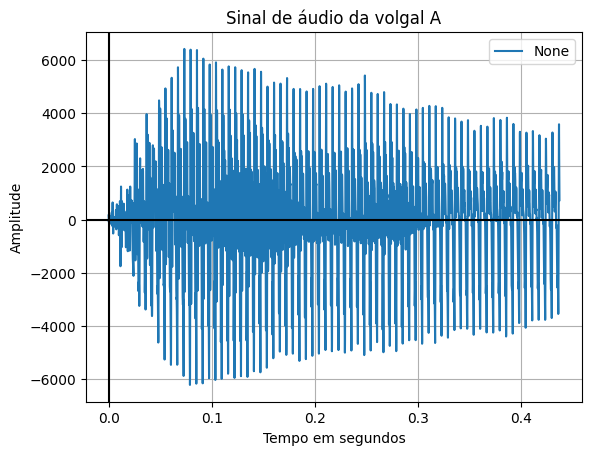

In [189]:
#Vogal A
fs_a, Vg_a = wav.read('2 - Fourier_Vogais_a.wav')
Na, T1a, Tvga, Pico_a, Ttot_a = extrai_vogal(fs_a, Vg_a)
plotar_grafico(Tvga, Vg_a, 'Sinal de áudio da volgal A', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_a, rate=fs_a)


Numero de pontos na vogal:  5722
Periodo de amostragem:  9.070294784580499e-05
Tempo total da vogal:  0.5189115646258503
Pico da vogal:  2829


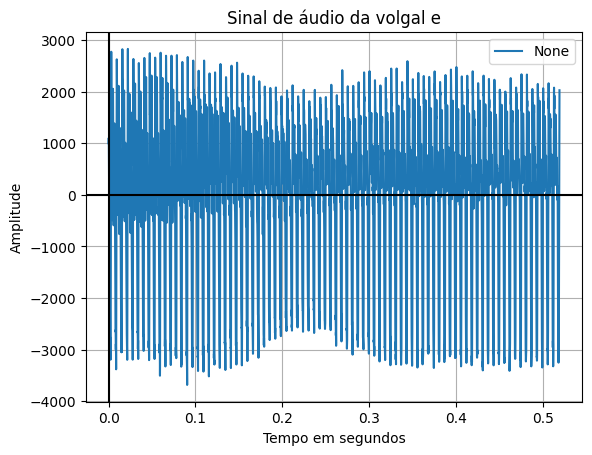

In [190]:
#Vogal E
fs_e, Vg_e = wav.read('2 - Fourier_Vogais_e.wav')
Ne, T1e, Tvge, Pico_e , Ttot_e = extrai_vogal(fs_e, Vg_e)
plotar_grafico(Tvge, Vg_e, 'Sinal de áudio da volgal e', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_e, rate=fs_e)

Numero de pontos na vogal:  3966
Periodo de amostragem:  9.070294784580499e-05
Tempo total da vogal:  0.3596371882086168
Pico da vogal:  2898


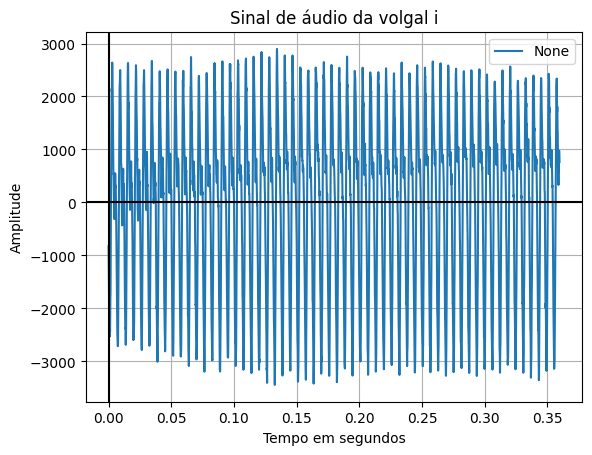

In [191]:
#Vogal I
fs_i, Vg_i = wav.read('2 - Fourier_Vogais_i.wav')
Ni, T1i, Tvgi, Pico_i, Ttot_i = extrai_vogal(fs_i, Vg_i)
plotar_grafico(Tvgi, Vg_i, 'Sinal de áudio da volgal i', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_i, rate=fs_i)

Numero de pontos na vogal:  4419
Periodo de amostragem:  9.070294784580499e-05
Tempo total da vogal:  0.4007256235827664
Pico da vogal:  3773


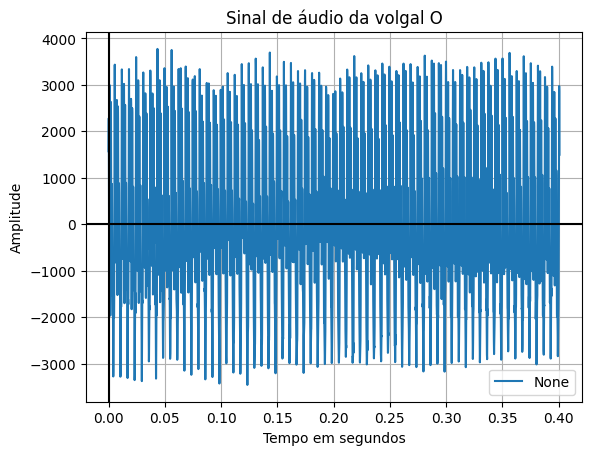

In [192]:
#Vogal O
fs_o, Vg_o = wav.read('2 - Fourier_Vogais_o.wav')
No, T1o, Tvgo, Pico_o, Ttot_o = extrai_vogal(fs_o, Vg_o)
plotar_grafico(Tvgo, Vg_o, 'Sinal de áudio da volgal O', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_o, rate=fs_o)

Numero de pontos na vogal:  6799
Periodo de amostragem:  9.070294784580499e-05
Tempo total da vogal:  0.6165986394557823
Pico da vogal:  2636


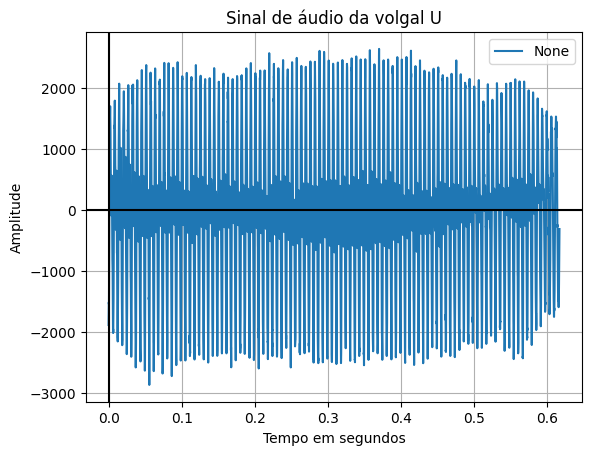

In [193]:
#Vogal U
fs_u, Vg_u = wav.read('2 - Fourier_Vogais_u.wav')
Nu, T1u, Tvgu, Pico_u, Ttot_u = extrai_vogal(fs_u, Vg_u)
plotar_grafico(Tvgu, Vg_u, 'Sinal de áudio da volgal U', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_u, rate=fs_u)

## Ponderando as vogais

<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

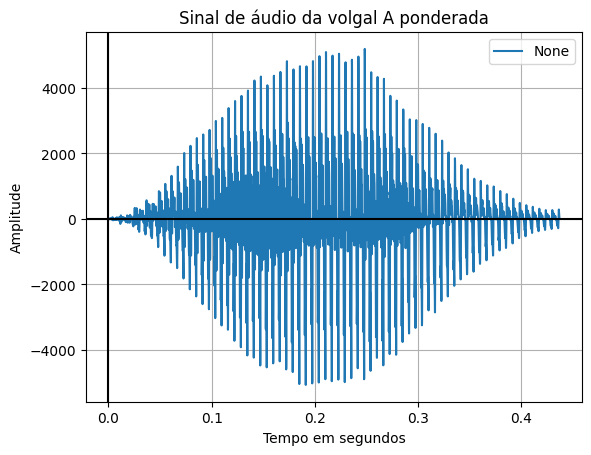

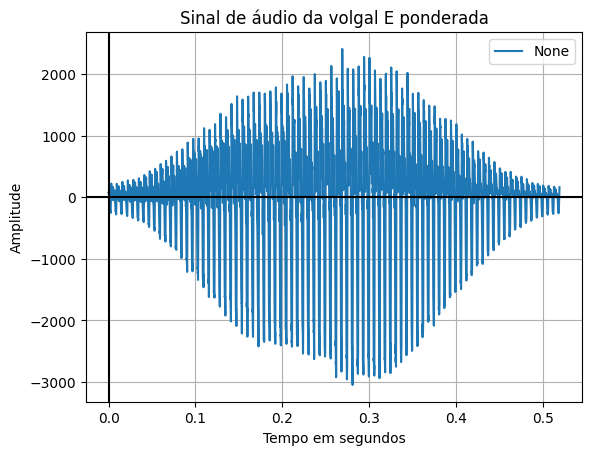

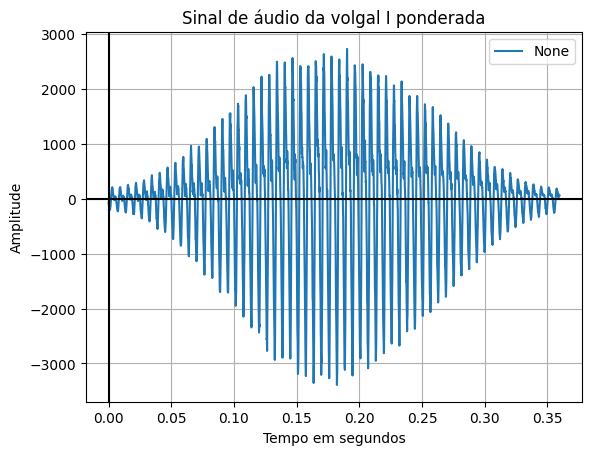

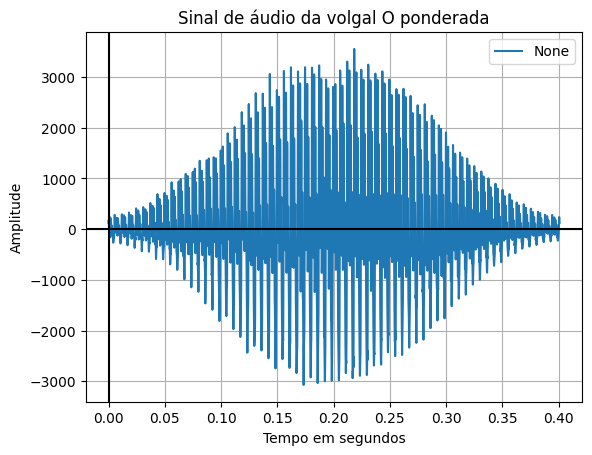

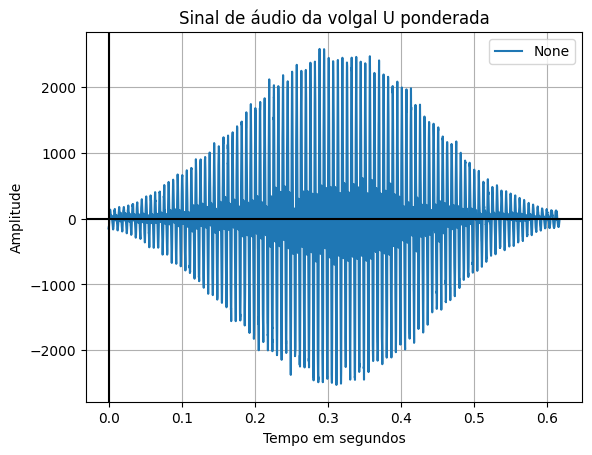

In [194]:
#Vogal A ponderada
Vg_ap = ponderar_vogal(Na, Vg_a)
plotar_grafico(Tvga, Vg_ap, 'Sinal de áudio da volgal A ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal E ponderada
Vg_ep = ponderar_vogal(Ne, Vg_e)
plotar_grafico(Tvge, Vg_ep, 'Sinal de áudio da volgal E ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal I ponderada
Vg_ip = ponderar_vogal(Ni, Vg_i)
plotar_grafico(Tvgi, Vg_ip, 'Sinal de áudio da volgal I ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal O ponderada
Vg_op = ponderar_vogal(No, Vg_o)
plotar_grafico(Tvgo, Vg_op, 'Sinal de áudio da volgal O ponderada', label_x='Tempo em segundos', label_y='Amplitude')

#Vogal U ponderada
Vg_up = ponderar_vogal(Nu, Vg_u)
plotar_grafico(Tvgu, Vg_up, 'Sinal de áudio da volgal U ponderada', label_x='Tempo em segundos', label_y='Amplitude')

# 2. Encontrar a frequência fundamental de cada vogal


## Vogal A

Frequência fundamental da vogal A:  2338 Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

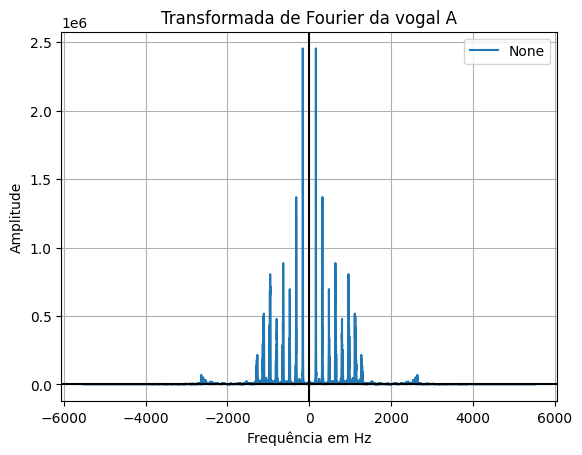

In [195]:
#Vogal A Fourier
Fourier_a, frequencia_a, freq_fund_a = calcula_fourier(Vg_ap, fs_a)
print('Frequência fundamental da vogal A: ', freq_fund_a,'Hz')
plotar_grafico(frequencia_a, Fourier_a, 'Transformada de Fourier da vogal A', label_x='Frequência em Hz', label_y='Amplitude')

In [201]:
plt.plot(frequencia_a, np.abs(np.abs(Fourier_a)))
plt.title('Fourrier da vogal A em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')

NameError: name 'axle_correction' is not defined

# Vogal E

Frequência fundamental da vogal E:  2779 Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

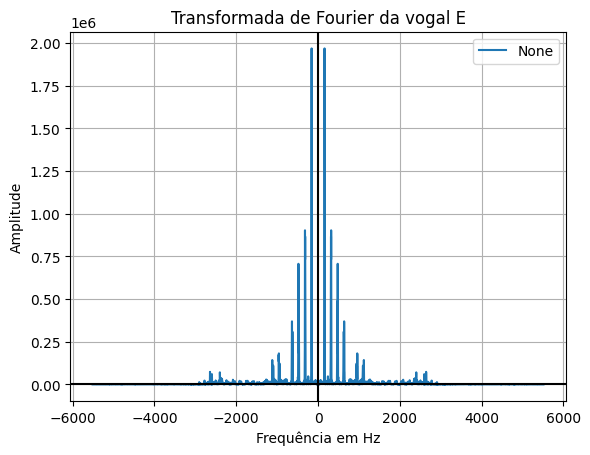

In [197]:
#Vogal E Fourier
Fourier_e, frequencia_e, freq_fund_e = calcula_fourier(Vg_ep, fs_e)
print('Frequência fundamental da vogal E: ', freq_fund_e,'Hz')
plotar_grafico(frequencia_e, Fourier_e, 'Transformada de Fourier da vogal E', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal I


Frequência fundamental da vogal I:  1925 Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

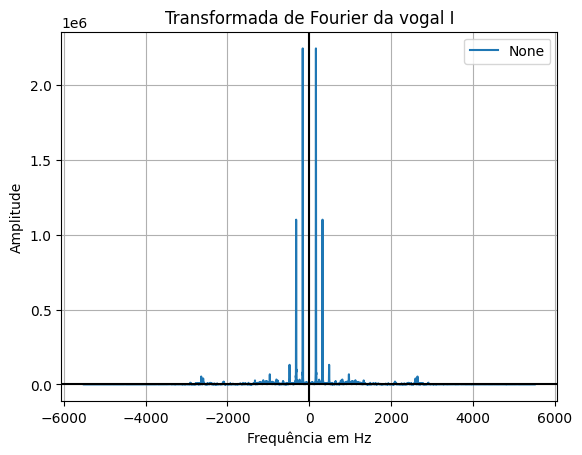

In [198]:
#Vogal I Fourier
Fourier_i, frequencia_i, freq_fund_i = calcula_fourier(Vg_ip, fs_i)
print('Frequência fundamental da vogal I: ', freq_fund_i,'Hz')
plotar_grafico(frequencia_i, Fourier_i, 'Transformada de Fourier da vogal I', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal O

Frequência fundamental da vogal O:  2145 Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

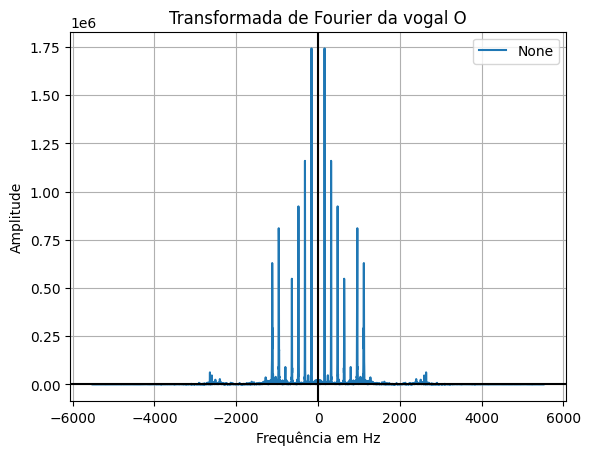

In [199]:
#Vogal O Fourier
Fourier_o, frequencia_o, freq_fund_o = calcula_fourier(Vg_op, fs_o)
print('Frequência fundamental da vogal O: ', freq_fund_o,'Hz')
plotar_grafico(frequencia_o, Fourier_o, 'Transformada de Fourier da vogal O', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal U

Frequência fundamental da vogal U:  3300 Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

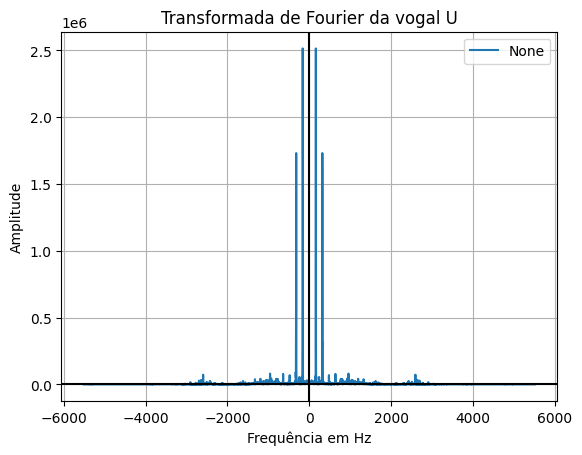

In [200]:
#Vogal U Fourier
Fourier_u, frequencia_u, freq_fund_u = calcula_fourier(Vg_up, fs_u)
print('Frequência fundamental da vogal U: ', freq_fund_u,'Hz')
plotar_grafico(frequencia_u, Fourier_u, 'Transformada de Fourier da vogal U', label_x='Frequência em Hz', label_y='Amplitude')

# 3. Encontrar a função de Laplace para um trecho de uma determinada vogal 